# Core Imports and Setup

In [1]:
import os
from pathlib import Path

import numpy as np

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("openff.toolkit").setLevel(logging.ERROR)

from openff import toolkit, evaluator

from openff.units import unit

from matplotlib import pyplot

from scipy.stats import linregress

# 0) Registering Custom ThermoML Properties

In [2]:
from openff.evaluator import properties
from openff.evaluator.datasets.thermoml import thermoml_property
from openff.evaluator.datasets import PhysicalProperty, PropertyPhase

@thermoml_property("Osmotic coefficient", supported_phases=PropertyPhase.Liquid)
class OsmoticCoefficient(PhysicalProperty):
    """A class representation of a osmotic coeff property"""

    @classmethod
    def default_unit(cls):
        return unit.dimensionless
    
...

custom_thermoml_props = [
    OsmoticCoefficient,
]

for custom_prop_cls in custom_thermoml_props:    
    setattr(properties, custom_prop_cls.__name__, custom_prop_cls)

# 1) - Loading ThermoML Data Sets

## Extracting data from ThermoML

In [3]:
from openff.evaluator.datasets import PhysicalProperty, PropertyPhase, PhysicalPropertyDataSet
from openff.evaluator.datasets.thermoml import thermoml_property, ThermoMLDataSet

data_set_initial = PhysicalPropertyDataSet.from_json("training-properties-with-water.json")
data_set_initial.to_pandas()

,Id,Temperature (K),Pressure (kPa),Phase,N Components,Component 1,Role 1,Mole Fraction 1,Exact Amount 1,Component 2,Role 2,Mole Fraction 2,Exact Amount 2,Density Value (g / ml),Density Uncertainty (g / ml),EnthalpyOfMixing Value (kJ / mol),EnthalpyOfMixing Uncertainty (kJ / mol),Source
0,6385,298.15,101.0,Liquid,2,CN1CCCCC1,Solvent,0.24520,None,O,Solvent,0.75480,None,0.903811,NaN,NaN,NaN,10.1016/j.fluid.2010.05.001
1,6386,298.15,101.0,Liquid,2,CN1CCCCC1,Solvent,0.50500,None,O,Solvent,0.49500,None,0.858158,NaN,NaN,NaN,10.1016/j.fluid.2010.05.001
2,6387,298.15,101.0,Liquid,2,CN1CCCCC1,Solvent,0.79070,None,O,Solvent,0.20930,None,0.826047,NaN,NaN,NaN,10.1016/j.fluid.2010.05.001
3,6388,298.15,101.3,Liquid,2,CN(C)CCO,Solvent,0.26433,None,O,Solvent,0.73567,None,0.959000,NaN,NaN,NaN,10.1021/acs.jced.6b00888
4,6389,298.15,101.3,Liquid,2,CN(C)CCO,Solvent,0.50770,None,O,Solvent,0.49230,None,0.923722,NaN,NaN,NaN,10.1016/j.jct.2004.11.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,7294,298.15,101.0,Liquid,2,C1COCCN1,Solvent,0.49110,None,O,Solvent,0.50890,None,NaN,NaN,-3.131,NaN,10.1016/j.jct.2015.06.006
119,7295,298.15,101.0,Liquid,2,C1COCCN1,Solvent,0.71490,None,O,Solvent,0.28510,None,NaN,NaN,-1.753,NaN,10.1016/j.jct.2015.06.006
120,7344,303.15,100.0,Liquid,2,NCCCNCCCN,Solvent,0.30050,None,O,Solvent,0.69950,None,NaN,NaN,-6.588,NaN,10.1016/j.jct.2015.04.030
121,7345,303.15,100.0,Liquid,2,NCCCNCCCN,Solvent,0.49980,None,O,Solvent,0.50020,None,NaN,NaN,-5.544,NaN,10.1016/j.jct.2015.04.030


In [4]:
print(len(data_set_initial))
print(data_set_initial.property_types)
print(data_set_initial.substances)

123
{'Density', 'EnthalpyOfMixing'}
{<Substance C1COCCN1{solv}{x=0.298000}|O{solv}{x=0.702000}>, <Substance OCCN1CCOCC1{solv}{x=0.694900}|O{solv}{x=0.305100}>, <Substance CC(C)O{solv}{x=0.231278}|O{solv}{x=0.768722}>, <Substance CNCCO{solv}{x=0.800900}|O{solv}{x=0.199100}>, <Substance OCCN(CCO)CCO{solv}{x=0.107783}|O{solv}{x=0.892217}>, <Substance CN1CCNCC1{solv}{x=0.550000}|O{solv}{x=0.450000}>, <Substance OCCN1CCOCC1{solv}{x=0.300200}|O{solv}{x=0.699800}>, <Substance Cc1cccnc1{solv}{x=0.700000}|O{solv}{x=0.300000}>, <Substance CN(C)CCCO{solv}{x=0.800100}|O{solv}{x=0.199900}>, <Substance NCCCO{solv}{x=0.751500}|O{solv}{x=0.248500}>, <Substance Cc1ccncc1{solv}{x=0.500000}|O{solv}{x=0.500000}>, <Substance OCCNCCO{solv}{x=0.406700}|O{solv}{x=0.593300}>, <Substance Cc1ccncc1{solv}{x=0.750000}|O{solv}{x=0.250000}>, <Substance CC(C)O{solv}{x=0.203100}|O{solv}{x=0.796900}>, <Substance NCCCO{solv}{x=0.272809}|O{solv}{x=0.727191}>, <Substance Cn1ccnc1{solv}{x=0.498200}|O{solv}{x=0.501800}>, <S

## Filtering data set

In [5]:
from openff.evaluator.datasets.curation.components.filtering import FilterByPropertyTypes, FilterByPropertyTypesSchema
from openff.evaluator.datasets.curation.components.filtering import FilterByTemperature, FilterByTemperatureSchema
from openff.evaluator.datasets.curation.components.filtering import FilterByPressure, FilterByPressureSchema
from openff.evaluator.datasets.curation.components.filtering import FilterBySmiles, FilterBySmilesSchema

data_set_hmix_dens= FilterByPropertyTypes.apply(
    data_set_initial, FilterByPropertyTypesSchema(property_types=["EnthalpyOfMixing","Density"]))

print(len(data_set_hmix_dens))

123


### Inspecting and saving new properties

In [6]:
# save for future use
data_set_path = Path('filtered_dataset_hmix_dens.json')
data_set_hmix_dens.json(data_set_path, format=True)

# inspect new properties
pandas_data_set = data_set_hmix_dens.to_pandas()

## 3) Analysing Data Sets

### Plotting results separately

In [7]:
def analysis_waters():

    water_models=('TIP3P','TIP3P_FB')

    for w in water_models:

        experimental_data_set_path = 'filtered_dataset_hmix_dens.json'
        estimated_data_set_path = '%s/estimated_dataset_hmix_dens.json' %w

        experimental_data_set = PhysicalPropertyDataSet.from_json(experimental_data_set_path)
        estimated_data_set = PhysicalPropertyDataSet.from_json(estimated_data_set_path)

        properties_by_type = {"Density": [], "EnthalpyOfMixing": []}

        for experimental_property in experimental_data_set:
            # Find the estimated property which has the same id as the
            # experimental property.
            estimated_property = next(
                x for x in estimated_data_set if x.id == experimental_property.id
            )

            # Add this pair of properties to the list of pairs
            property_type = experimental_property.__class__.__name__
            properties_by_type[property_type].append(
                (experimental_property, estimated_property)
            )
        
        # Create the figure we will plot to.
        figure, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(10.0, 5.0))

        # Set the axis titles
        axes[0].set_xlabel("OpenFF 2.1.0")
        axes[0].set_ylabel("Experimental")
        axes[0].set_title("Density $kg m^{-3}$ - %s" %w)

        axes[1].set_xlabel("OpenFF 2.1.0")
        axes[1].set_ylabel("Experimental")
        axes[1].set_title("$H_{mix}$ $kJ mol^{-1}$ - %s" %w)

        # Define the preferred units of the properties
        from openff.units import unit

        preferred_units = {
            "Density": unit.kilogram / unit.meter**3,
            "EnthalpyOfMixing": unit.kilojoule / unit.mole,
        }

        for index, property_type in enumerate(properties_by_type):
            experimental_values = []
            estimated_values = []

            preferred_unit = preferred_units[property_type]

            # Convert the values of our properties to the preferred units.
            for experimental_property, estimated_property in properties_by_type[property_type]:
                experimental_values.append(
                    experimental_property.value.to(preferred_unit).magnitude
                )
                estimated_values.append(estimated_property.value.to(preferred_unit).magnitude)

            axes[index].plot(
                estimated_values, experimental_values, marker="x", linestyle="None"
            )
        

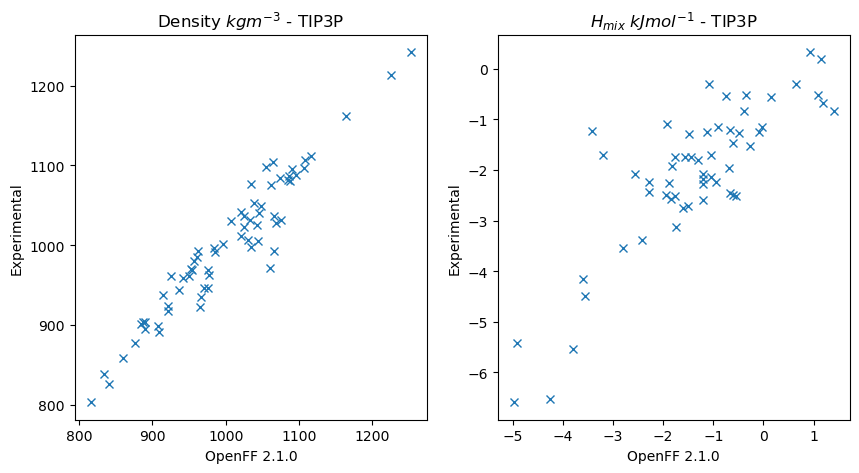

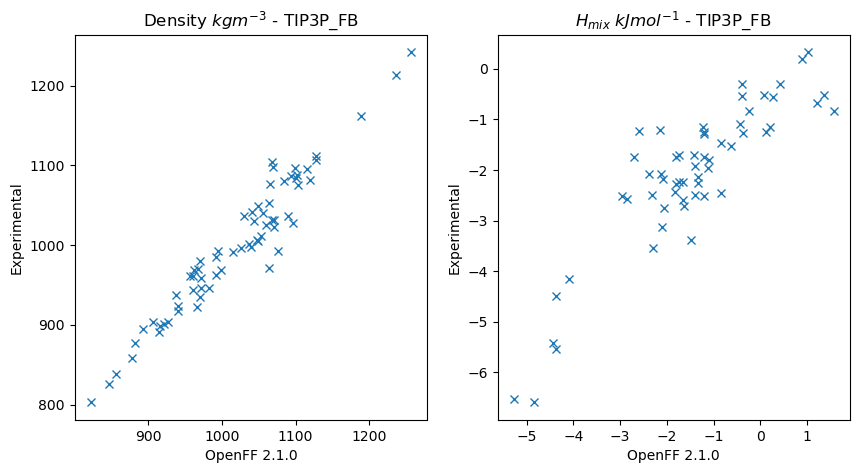

In [8]:
analysis_waters()

### Plotting results all together

In [9]:
def analysis_all(phys_prop,water_model):
    
    experimental_data_set_path = 'filtered_dataset_hmix_dens.json'
    estimated_data_set_path = ('%s/estimated_dataset_hmix_dens.json'%water_model)

    experimental_data_set = PhysicalPropertyDataSet.from_json(experimental_data_set_path)
    estimated_data_set = PhysicalPropertyDataSet.from_json(estimated_data_set_path)

    properties_by_type = {phys_prop: []}

    for experimental_property in experimental_data_set:

        if (type(experimental_property).__qualname__) == phys_prop:
    #     # Find the estimated property which has the same id as the
    #     # experimental property.
            property_type = experimental_property.__class__.__name__
            estimated_property = next(
                x for x in estimated_data_set if x.id == experimental_property.id
            )
            # Add this pair of properties to the list of pairs
            properties_by_type[property_type].append((experimental_property, estimated_property))
    
    preferred_units = {
        "Density": unit.kilogram / unit.meter**3,
        "EnthalpyOfMixing": unit.kilojoule / unit.mole,
    }

    experimental_values = []
    estimated_values = []
    preferred_unit = preferred_units[property_type]
    
    for experimental_property, estimated_property in properties_by_type[property_type]:
        experimental_values.append(
            experimental_property.value.to(preferred_unit).magnitude
        )
        estimated_values.append(
            estimated_property.value.to(preferred_unit).magnitude
        )

    def results_stats(x,y):    
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        r2_value=r_value**2
        
        stats=dict()
        stats['slope']=slope
        stats['intercept']=intercept
        stats['r_value']=r_value
        stats['r2_value']=r2_value
        stats['p_value']=p_value
        stats['std_err']=std_err
        return stats

    results=dict()
    results["%s:%s-Experimental_Values" %(water_model,phys_prop)]=experimental_values
    results["%s:%s-Estimated_Values" %(water_model,phys_prop)]=estimated_values
    results["%s:%s-Stats" %(water_model,phys_prop)]=results_stats(estimated_values,experimental_values)
    
    return results

In [10]:
waters=('TIP3P','TIP3P_FB')

results=dict()

for w in waters:
    # hmix_result=analysis_hmix(w)
    dens_result=analysis_all('Density', w)
    results.update(dens_result)
    hmix_result=analysis_all('EnthalpyOfMixing',w)
    results.update(hmix_result)

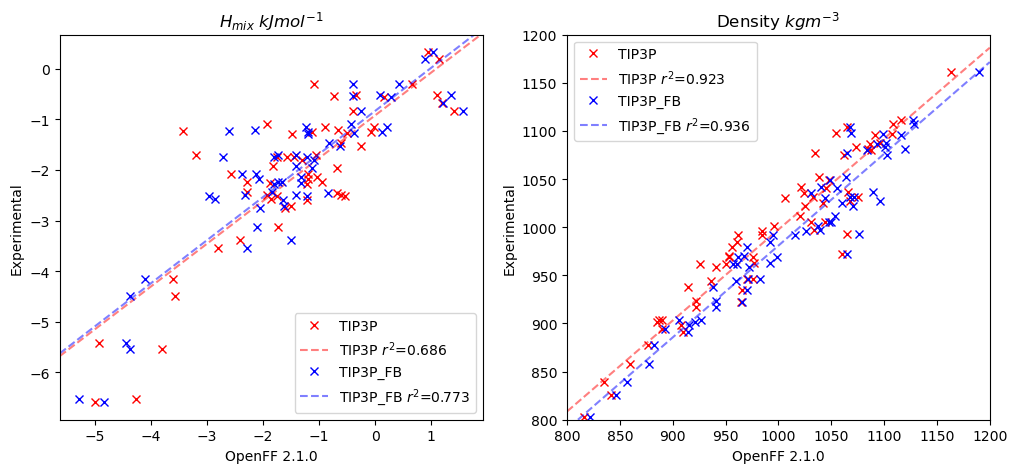

In [42]:
plt.figure(figsize=(12.0, 5.0))

plt.subplot(1,2,1)
plt.plot(results['TIP3P:EnthalpyOfMixing-Estimated_Values'], results['TIP3P:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='r', label='TIP3P')
plt.axline(xy1=(0,results['TIP3P:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP3P:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='r', alpha=0.5, label='TIP3P $r^{2}$=%.3f'%results['TIP3P:EnthalpyOfMixing-Stats']['r2_value'])
plt.plot(results['TIP3P_FB:EnthalpyOfMixing-Estimated_Values'], results['TIP3P_FB:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='b',label='TIP3P_FB')
plt.axline(xy1=(0,results['TIP3P_FB:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP3P_FB:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='b', alpha=0.5, label='TIP3P_FB $r^{2}$=%.3f'%results['TIP3P_FB:EnthalpyOfMixing-Stats']['r2_value'])
plt.title('$H_{mix}$ $kJ mol^{-1}$')
plt.xlabel('OpenFF 2.1.0')
plt.ylabel('Experimental')
plt.legend()

plt.subplot(1,2,2)
plt.plot(results['TIP3P:Density-Estimated_Values'], results['TIP3P:Density-Experimental_Values'], marker='x', linestyle='None', color='r', label='TIP3P')
plt.axline(xy1=(0,results['TIP3P:Density-Stats']['intercept']),slope=results['TIP3P:Density-Stats']['slope'], linestyle="--", color='r', alpha=0.5, label='TIP3P $r^{2}$=%.3f'%results['TIP3P:Density-Stats']['r2_value'])
plt.plot(results['TIP3P_FB:Density-Estimated_Values'], results['TIP3P_FB:Density-Experimental_Values'], marker='x', linestyle='None', color='b',label='TIP3P_FB')
plt.axline(xy1=(0,results['TIP3P_FB:Density-Stats']['intercept']),slope=results['TIP3P_FB:Density-Stats']['slope'], linestyle="--", color='b', alpha=0.5, label='TIP3P_FB $r^{2}$=%.3f'%results['TIP3P_FB:Density-Stats']['r2_value'])
plt.xlim(800,1200)
plt.ylim(800,1200)
plt.title("Density $kg m^{-3}$")
plt.xlabel('OpenFF 2.1.0')
plt.ylabel('Experimental')
plt.legend()

plt.savefig('hmix_dens_plot.png')

plt.show()